In [1]:
!git clone https://github.com/soumik12345/Neural-Style-Transfer

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 46 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (46/46), done.


In [0]:
import warnings, os, random
warnings.filterwarnings('ignore')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import tensorflow as tf
import tensorflow.contrib.eager as tfe
from tensorflow.python.keras import models 

In [0]:
artwork_location = './Neural-Style-Transfer/Artworks/'
content_location = './Neural-Style-Transfer/TestCases/'
artworks = os.listdir(artwork_location)
content = os.listdir(content_location)

In [0]:
content_path = content_location + random.choice(content)
style_path = artwork_location + random.choice(artworks)
height = 480
width = 640

In [6]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
def load_img(location):
    img = cv2.resize(cv2.cvtColor(cv2.imread(location), cv2.COLOR_BGR2RGB), (width, height))
    img = np.expand_dims(img, axis = 0).astype('uint8')
    return img

In [0]:
def imshow(img, title = ""):
    if img.ndim == 4:
        img = np.squeeze(img, axis = 0).astype(np.uint8)
    plt.imshow(img)
    if title != "":
        plt.title(title)
    plt.xticks([])
    plt.yticks([])

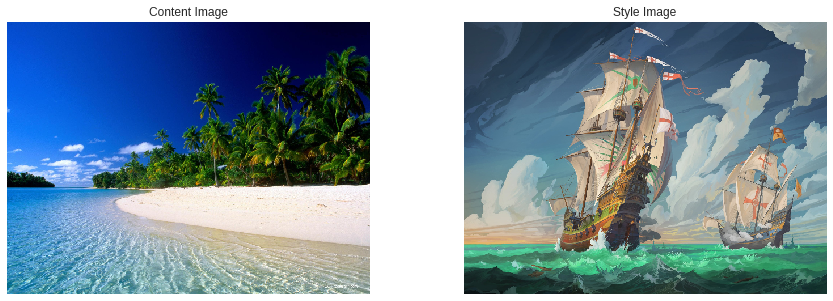

In [9]:
content = load_img(content_path)
style = load_img(style_path)

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
imshow(content, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [0]:
def load_and_process_img(location):
    img = load_img(location)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [0]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def get_model():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    return models.Model(vgg.input, model_outputs)

In [0]:
def get_content_loss(base_content, target):
      return tf.reduce_mean(tf.square(base_content - target))

In [0]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a = True)
    return gram / tf.cast(n, tf.float32)

In [0]:
def get_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [0]:
def get_feature_representations(model, content_path, style_path):
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    style_score = 0
    content_score = 0
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
    style_score *= style_weight
    content_score *= content_weight
    loss = style_score + content_score 
    return loss, style_score, content_score

In [0]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [0]:
def run_style_transfer(content_path, style_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2): 

    model = get_model() 

    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
    
    init_image = load_and_process_img(content_path)
    init_image = tfe.Variable(init_image, dtype = tf.float32)
    
    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)
    loss_weights = (style_weight, content_weight)
    
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    display_interval = 100

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   

    best_loss, best_img = float('inf'), None
    total_loss_hist, style_score_hist, content_score_hist = [], [], []
    
    
    print('\n\nStarted Transferring Style\n')
    print('-' * 70)
    
    for i in range(1, num_iterations+1):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        if loss < best_loss:
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())
        if i % display_interval == 0:
            total_loss_hist.append(loss)
            style_score_hist.append(style_score)
            content_score_hist.append(content_score)
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, style loss: {:.4e}, content loss: {:.4e}'.format(loss, style_score, content_score))
    
    print('-' * 70)
    print('\nStyle Transferred\n')
    total_loss_hist = np.array(total_loss_hist)
    style_score_hist = np.array(style_score_hist)
    content_score_hist = np.array(content_score_hist)
    return best_img, total_loss_hist, style_score_hist, content_score_hist

In [22]:
best, total_loss_hist, style_score_hist, content_score_hist = run_style_transfer(content_path, style_path, num_iterations = 2500)

Instructions for updating:
Colocations handled automatically by placer.
80142336/80134624 [==============================] - 21s 0us/step


Started Transferring Style

----------------------------------------------------------------------
Iteration: 100
Total loss: 2.5256e+06, style loss: 1.6070e+06, content loss: 9.1859e+05
Iteration: 200
Total loss: 1.2116e+06, style loss: 5.9527e+05, content loss: 6.1634e+05
Iteration: 300
Total loss: 7.7103e+05, style loss: 3.2315e+05, content loss: 4.4788e+05
Iteration: 400
Total loss: 5.7397e+05, style loss: 2.2109e+05, content loss: 3.5288e+05
Iteration: 500
Total loss: 4.7286e+05, style loss: 1.7393e+05, content loss: 2.9894e+05
Iteration: 600
Total loss: 4.1405e+05, style loss: 1.4856e+05, content loss: 2.6549e+05
Iteration: 700
Total loss: 3.7675e+05, style loss: 1.3307e+05, content loss: 2.4368e+05
Iteration: 800
Total loss: 3.5093e+05, style loss: 1.2257e+05, content loss: 2.2836e+05
Iteration: 900
Total loss: 3.3188e+05, style loss: 1.1483

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))
total_loss_hist_scaled = scaler.fit_transform(np.expand_dims(total_loss_hist, 1))
style_score_hist_scaled = scaler.fit_transform(np.expand_dims(style_score_hist, 1))
content_score_hist_scaled = scaler.fit_transform(np.expand_dims(content_score_hist, 1))

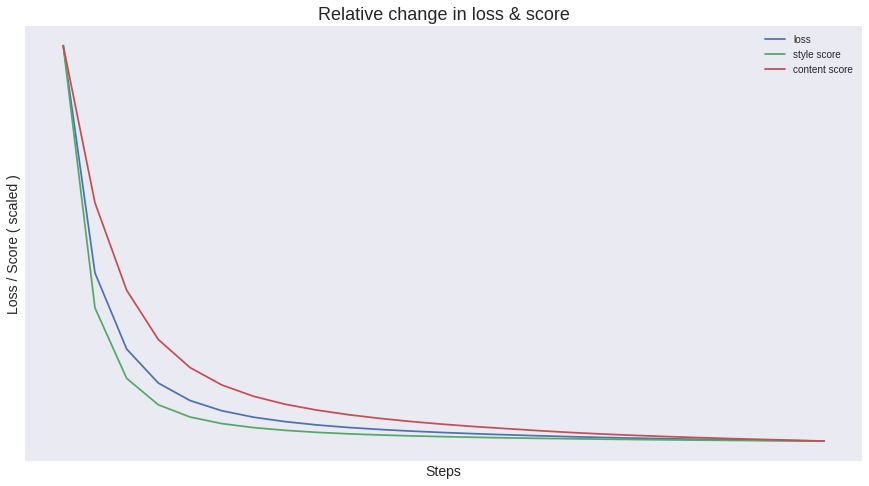

In [24]:
plt.figure(figsize=(15,8))
plt.plot(list(range(len(total_loss_hist))), total_loss_hist_scaled, label = 'loss')
plt.plot(list(range(len(style_score_hist))), style_score_hist_scaled, label = 'style score')
plt.plot(list(range(len(content_score_hist))), content_score_hist_scaled, label = 'content score')
plt.xticks([])
plt.yticks([])
plt.title("Relative change in loss & score", fontsize=18)
plt.ylabel('Loss / Score ( scaled )', fontsize=14)
plt.xlabel('Steps', fontsize=14)
plt.legend()
plt.show()

In [0]:
def show_results(best_img, content_path, style_path):
    content = load_img(content_path) 
    style = load_img(style_path)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')
    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')
    plt.figure(figsize=(12, 10))
    imshow(best_img, 'Output Image')
    plt.show()

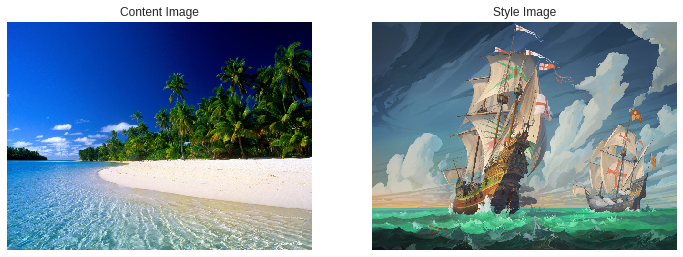

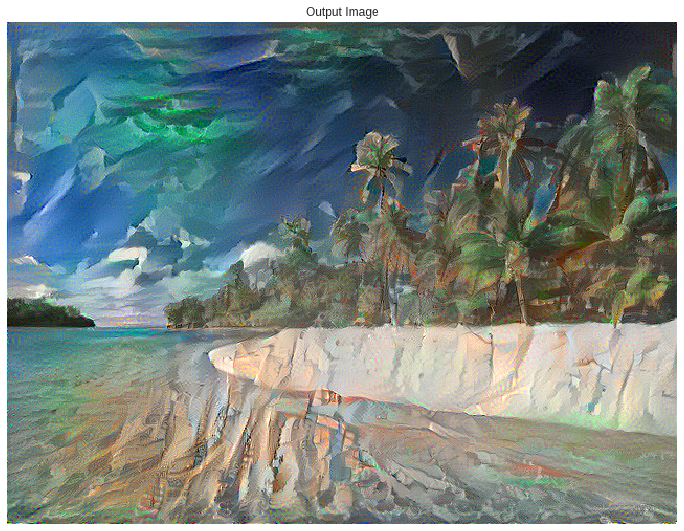

In [26]:
show_results(best, content_path, style_path)